In [1]:
import pandas as pd

def Room(house):
    i = house.find('室')
    j = house.find('厅')
    room = house[0:i]
    if room != '--':
        return int(room)
    else:
        return -1

def LivingRoom(house):
    i = house.find('室')
    j = house.find('厅')
    living = house[i + 1:j]
    if living != '--':
        return int(living)
    else:
        return -1

def square(mianji):
    s = mianji[0:mianji.find('平')]
    if s == '0':
        return -1
    elif s != '--':
        return int(s)
    else:
        return -1

def CJdanjia(cjdanjia):
    s = cjdanjia[0:cjdanjia.find('元')]
    if int(s) <= 9999:
        return -1
    else:
        return int(s)

def Comp(line, xiaoqu, mendian,attribute):
    room = line['room']
    living = line['living']
    mianji = line['mianji']
    danjia = line['danjia']
    xiaoqu_name = line['xiaoqu']
    mendian_name = line['mendian']

    xiaoqu_set = xiaoqu.get_group(xiaoqu_name).reset_index(drop=True)
    mendian_set = mendian.get_group(mendian_name).reset_index(drop=True)

    xiaoqu_mean = round(xiaoqu_set[attribute].mean())
    mendian_mean = round(mendian_set[attribute].mean())

    xiaoqu_set = xiaoqu_set.drop(xiaoqu_set[xiaoqu_set[attribute] == -1].index).reset_index(drop=True)
    mendian_set = mendian_set.drop(mendian_set[mendian_set[attribute] == -1].index).reset_index(drop=True)

    distance_xiaoqu = abs((xiaoqu_set['room'] - room) * 20) + abs((xiaoqu_set['living'] - living) * 20) +  \
               abs(xiaoqu_set['mianji'] - mianji) + abs(xiaoqu_set['danjia'] - danjia)

    distance_mendian = abs((mendian_set['room'] - room) * 20) + abs((mendian_set['living'] - living) * 20) +  \
               abs(mendian_set['mianji'] - mianji) + abs(mendian_set['danjia'] - danjia)

    if distance_xiaoqu.empty and distance_mendian.empty:
        if xiaoqu_set.__len__() < 2:
            return mendian_mean
        else:
            return xiaoqu_mean
    elif ~distance_xiaoqu.empty and ~distance_mendian.empty:
        if distance_xiaoqu.min()<distance_mendian.min():
            index = distance_xiaoqu.idxmin()
            return xiaoqu_set.iloc[index][attribute]
        else:
            index = distance_mendian.idxmin()
            return mendian_set.iloc[index][attribute]
    elif ~distance_xiaoqu.empty and distance_mendian.empty:
        index = distance_mendian.idxmin()
        return mendian_set.iloc[index][attribute]
    else:
        index = distance_xiaoqu.idxmin()
        return xiaoqu_set.iloc[index][attribute]


data = pd.read_csv('./data/lianjia.csv',encoding='gbk')
data['xiaoqu'],data['huxing'],data['mianji']=data['cjxiaoqu'].str.split(' ').str
data['room'] = data['huxing'].map(Room).fillna(-1)
data['living'] = data['huxing'].map(LivingRoom).fillna(-1)
data['mianji'] = data['mianji'].map(square).fillna(-1)
data['danjia'] = data['cjdanjia'].map(CJdanjia).fillna(-1)
xiaoqu_mean = data.groupby('xiaoqu')['mianji'].mean().astype(int)
mendian_mean = data.groupby('mendian')['mianji'].mean().astype(int)
mendian = data.groupby('mendian')
xiaoqu = data.groupby('xiaoqu')

for i in range(0,data.__len__()):
#i = 243
    line = data.iloc[i]

    if line['room'] == -1:
        line['room'] = Comp(line,xiaoqu,mendian,'room')

    if line['living'] == -1:
        line['living'] = Comp(line, xiaoqu, mendian,'living')

    if line['mianji'] <= 0:
        line['mianji'] = Comp(line, xiaoqu, mendian,'mianji')

    if line['danjia'] <= 0:
        line['danjia'] = Comp(line, xiaoqu, mendian,'danjia')
        line['cjzongjia'] = line['mianji'] * line['danjia'] / 10000

    data.iloc[i] = line

data['room'] = data['room'].astype(str)
data['living'] = data['living'].astype(str)
data['mianji'] = data['mianji'].astype(str)
data['danjia'] = data['danjia'].astype(str)
data['danjia'] = data['danjia']+'元/平'

data['new'] = data['xiaoqu']+' '+data['room']+'室'+data['living']+'厅'+' '+data['mianji']+'平'

data.drop(['huxing','room','mianji','cjdanjia','living','cjxiaoqu'], axis=1)
data.to_csv('lianjia.csv',encoding='gbk',columns=['cjtaoshu','mendian','cjzongjia','zhiwei','haoping','danjia',
                                                  'new','xingming','cjzhouqi','biaoqian','cjlouceng','cjshijian',
                                                  'congyenianxian','bankuai'])



FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\lianjia1.csv'

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [15]:
print('加载数据集')
data = pd.read_csv('./data/lianjia.csv', index_col=0,encoding='gbk')
print('属性类别数:', len(data.columns))
print('总行数:', len(data))
print('示例数据:')
data.head(5)

加载数据集
属性类别数: 14
总行数: 1556
示例数据:


,cjtaoshu,mendian,cjzongjia,zhiwei,haoping,danjia,new,xingming,cjzhouqi,biaoqian,cjlouceng,cjshijian,congyenianxian,bankuai
0,37,红莲北里店,251.0,店经理,97% 141,43997元/平,红莲北里 3室1厅 57平,郭海龙,36,房东信赖;销售达人;带看活跃,南 北/高楼层/6层,签约时间：2015-05-24,4-5年,马连道
1,37,红莲北里店,159.0,店经理,97% 141,36969元/平,红莲南里 1室1厅 43平,郭海龙,36,房东信赖;销售达人;带看活跃,南/高楼层/7层,签约时间：2015-05-10,4-5年,马连道
2,37,红莲北里店,257.0,店经理,97% 141,39046元/平,常青藤嘉园 1室1厅 65平,郭海龙,36,房东信赖;销售达人;带看活跃,北/低楼层/16层,签约时间：2015-04-26,4-5年,马连道
3,37,红莲北里店,243.0,店经理,97% 141,41313元/平,红莲北里 2室1厅 58平,郭海龙,36,房东信赖;销售达人;带看活跃,南 北/高楼层/6层,签约时间：2015-04-04,4-5年,马连道
4,37,红莲北里店,372.5,店经理,97% 141,42053元/平,广安门外大街 3室1厅 88平,郭海龙,36,房东信赖;销售达人;带看活跃,东 南 西 北/中楼层/18层,签约时间：2015-04-01,4-5年,马连道


In [16]:
print('提取每一列属性以及名称')
num_fields = data.select_dtypes(include=np.number).columns.values
nom_fields = data.select_dtypes(exclude=np.number).columns.values
print('标称属性:', nom_fields)
print('数值属性:', num_fields)
print(data.shape," ",nom_fields.shape," ",num_fields.shape)

提取每一列属性以及名称
标称属性: ['mendian' 'zhiwei' 'haoping' 'danjia' 'new' 'xingming' 'biaoqian'
 'cjlouceng' 'cjshijian' 'congyenianxian' 'bankuai']
数值属性: ['cjtaoshu' 'cjzongjia' 'cjzhouqi']
(1556, 14)   (11,)   (3,)


In [17]:
print("统计每一个属性的个数")
print('\nmendian(门店):')
a=data['mendian'].value_counts()
print(a)

print('\nzhiwei(职位):')
b=data['zhiwei'].value_counts()
print(b)

print('\nhaoping(好评):')
c=data['haoping'].value_counts()
print(c)

print('\ndanjia(成交单价):')
d=data['danjia'].value_counts()
print(d)

print('\nnew(成交单价):')
d1=data['new'].value_counts()
print(d1)

print('\nxingming(姓名):')
e=data['xingming'].value_counts()
print(e)

print('\nbiaoqian(标签):')
f=data['biaoqian'].value_counts()
print(f)

print('\ncjlouceng(成交楼层):')
g=data['cjlouceng'].value_counts()
print(g)

print('\ncjshijian(成交时间):')
h=data['cjshijian'].value_counts()
print(h)

print('\ncongyenianxian(从月年限):')
i=data['congyenianxian'].value_counts()
print(i)

print('\nbankuai(板块):')
j=data['bankuai'].value_counts()
print(j)


mendian(门店):
老山旗舰店        78
皂君东里店        51
光彩路一店        50
永乐店          45
苹果店          45
月华轩店         40
东风北桥店        40
阳光花园店        40
安德路店         40
团结湖店         40
华清嘉园新店       40
太东店          40
乐成豪丽店        40
南方庄店         40
新武夷花园店       40
新建欣苑店        40
首开常青藤店       40
日坛国际店        40
二里庄南店        40
融景城店         40
莲香园店         40
白家庄小学店       40
苹果园大街店       40
马坡店          40
富力又一城四临时店    40
新城中心店        38
龙跃店          37
华尔街店         37
红莲北里店        37
银河大街店        37
裕民路店         36
逸成东苑店        35
朝内小街店        35
马连道中里店       34
定慧福里店        34
新街口西里一区店     33
龙泽城铁店        26
金尚嘉园店        26
志新店          24
交东小区店        18
Name: mendian, dtype: int64

zhiwei(职位):
店经理    1385
经纪人     171
Name: zhiwei, dtype: int64

haoping(好评):
94% 281     82
95% 414     78
97% 220     51
95% 218     50
91% 211     45
98% 137     40
96% 255     40
98% 183     40
93% 271     40
96% 151     40
97% 325     40
93% 117     40
86% 142     40
97% 204     40
97% 118     40
90% 193     40


In [18]:
data.describe()

,cjtaoshu,cjzongjia,cjzhouqi
count,1556.000000,1556.000000,1556.000000
mean,54.829049,329.726904,47.701157
std,23.388382,188.080727,13.805261
min,18.000000,14.118000,19.000000
25%,37.000000,201.375000,40.000000
50%,48.000000,283.000000,45.000000
75%,65.750000,405.000000,55.000000
max,118.000000,1560.000000,80.000000


数据可视化：

数据太多导致显示数据出现重叠看不清具体值，所以取前20个为例:
cjzongjia前20个样例:


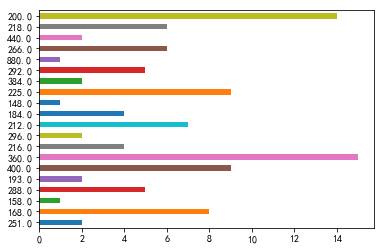

cjzhouqi前20个样例:


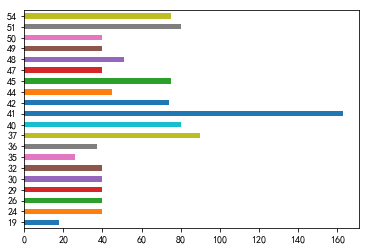

danjia前20个样例:


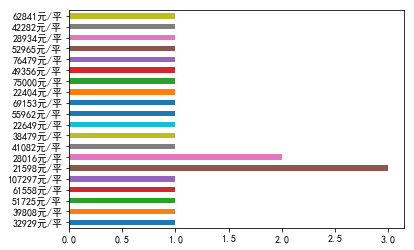

cjtaoshu前20个样例:


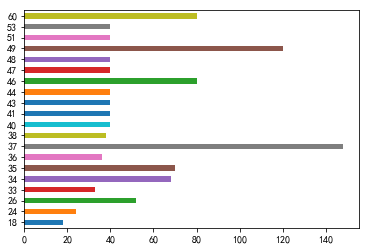

In [19]:
print('数据可视化：\n')
field = ['cjzongjia','cjzhouqi','danjia','cjtaoshu']
print('数据太多导致显示数据出现重叠看不清具体值，所以取前20个为例:')

for fie in field:
    print("{}前20个样例:".format(fie))
    data[fie].value_counts(sort=False).head(20).plot.barh()
    plt.show()

画出不同店家的成交数量饼图


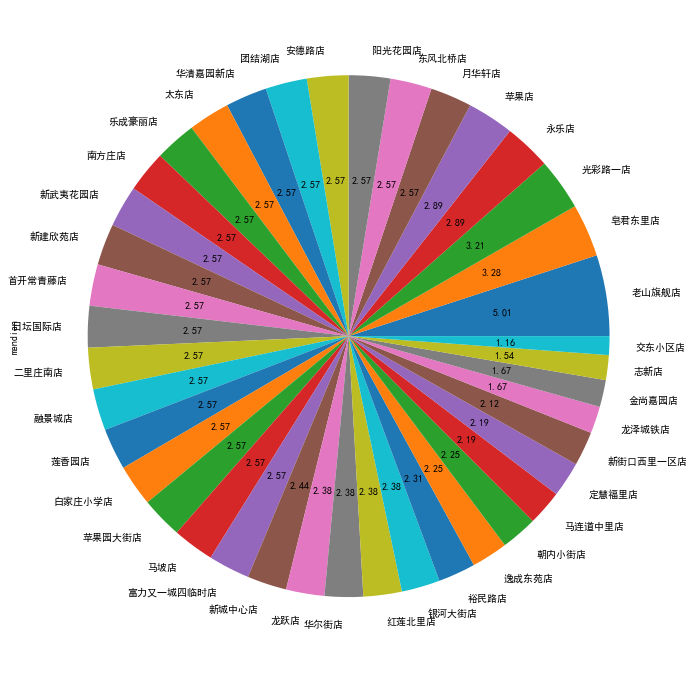

In [20]:
print("画出不同店家的成交数量饼图")
label=[]
for key in data['mendian'].value_counts().index:
    label.append(key)

data['mendian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=10,figsize=(12, 12))

画出不同从月年限的饼图


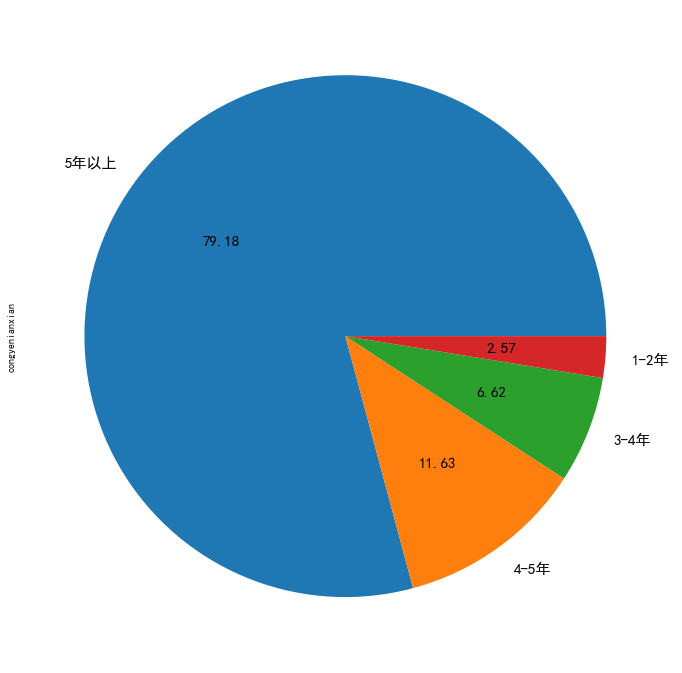

In [21]:
print("画出不同从月年限的饼图")
label=[]
for key in data['congyenianxian'].value_counts().index:
    label.append(key)

data['congyenianxian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))

画出不同板块（地区）的饼图


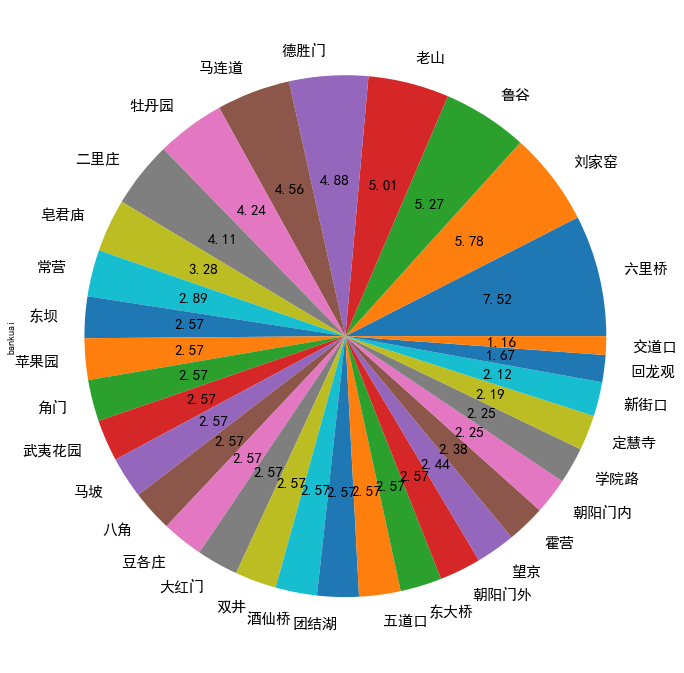

In [22]:
print("画出不同板块（地区）的饼图")
label=[]
for key in data['bankuai'].value_counts().index:
    label.append(key)

data['bankuai'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))

画出不同标签的饼图


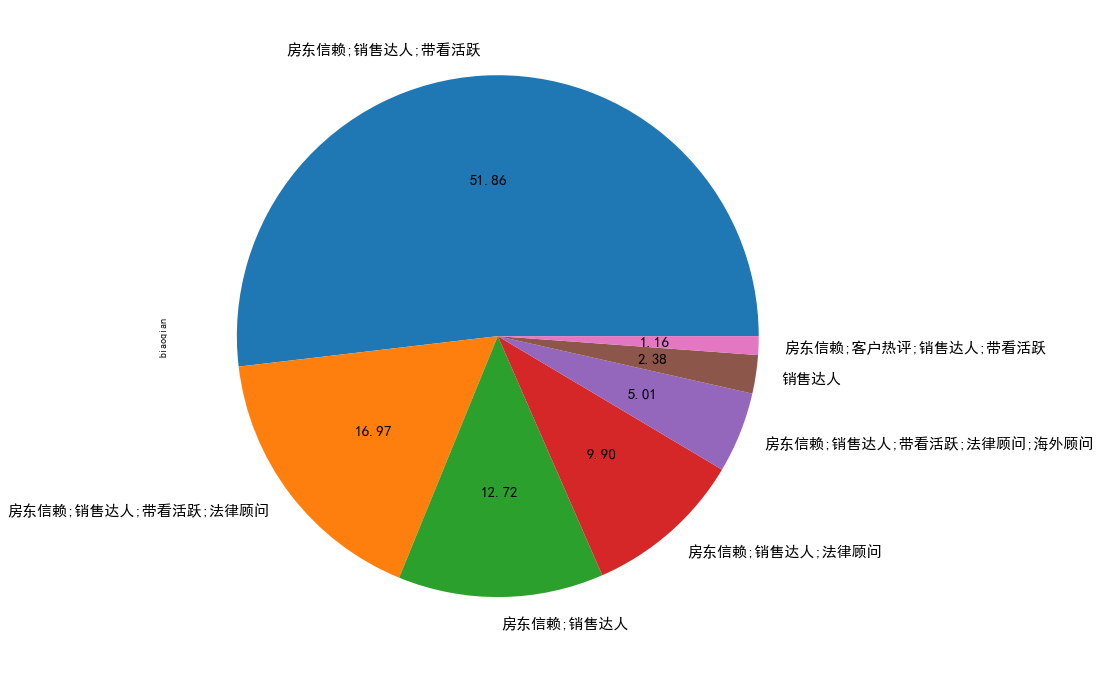

In [23]:
print("画出不同标签的饼图")
label=[]
for key in data['biaoqian'].value_counts().index:
    label.append(key)

data['biaoqian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))